In [75]:
%matplotlib inline
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns

In [76]:
sys.path.append(os.path.realpath('..'))

avail_data_file = "hourly-avg-2017-06-all-stations.csv"
weather_data_file = "fmi-weatherdata-Helsinki-Kaisaniemi-2017.csv"

In [77]:
# Read and combine data
bikeData = pd.read_csv(avail_data_file, sep=',')
weatherData = pd.read_csv(weather_data_file, sep=",")

weatherData.rename(columns={'Vuosi': 'Year', 'Kk': 'Month', 'Pv': 'Day', 'Klo': 'Time', 'Aikavyöhyke': 'Timezone', 'Sateen intensiteetti (mm/h)': 'rainIntensity_mmh', 'Ilman lämpötila (degC)': 'temperature_c'}, inplace=True)  

In [78]:
# Filter only June 2017
weatherData = weatherData[weatherData.Month == 6]

# Reset dataframe indices to make combining work properly
bikeData = bikeData.reset_index(drop=True)
weatherData = weatherData.reset_index(drop=True)

bikeData['rainIntensity_mmh'] = weatherData['rainIntensity_mmh']
bikeData['temperature_c'] = weatherData['temperature_c']

In [79]:
# Assigning 'sumofhourlyavg' as the dependent variable y
# Assigning 'Sade' and 'Ilman_lampotila' as independent variables X (X is 2xn matrix here but it will still need the weekday-info and hour-columns to be complete)
X = bikeData.loc[:, ['rainIntensity_mmh','temperature_c']] # matrix of independent variables 'rainIntensity_mmh' and 'temperature_c'
y = bikeData[bikeData.columns[1]] # vector of 'sumofhourlyavg'

# Add hour to the matrix of independent variables
bikeData['hour'] = bikeData['timehour'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").hour)

# Add month to the matrix of independent variables
#X['month'] = bikeData['timehour'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month)

# Add weekday to the matrix of independent variables. 0 is Monday, 6 is Sunday.
#X['weekday'] = bikeData['timehour'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").weekday())

# Investigating weekday, I found that some variance was explained by it, but _very_ little
bikeData['weekday'] = bikeData['timehour'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").weekday())

# Applied moving average to transform the data (rainIntensity) with 8 hours history 
bikeData['rain_MA'] = np.zeros(len(bikeData['sumofhourlyavg']))
moving_average_window_size = 8

for i in range(len(weatherData['rainIntensity_mmh'])):
    avg_val = 0
    sum_count = 0
    for j in range(moving_average_window_size):
        if (i-j >= 0):
            avg_val += weatherData['rainIntensity_mmh'].values[i-j] # moving average
            sum_count += 1
    avg_val /= sum_count
    bikeData['rain_MA'].values[i] = avg_val

drop_indices = []
for i in range(len(bikeData['rain_MA'])):
    if (bikeData['rain_MA'][i] == 0):
        drop_indices = drop_indices+[i]

# zero values are dropped here so that only points with recent rain appear on the scatterplot
bikeData['rain_MA'] = bikeData['rain_MA'].drop(labels=drop_indices)

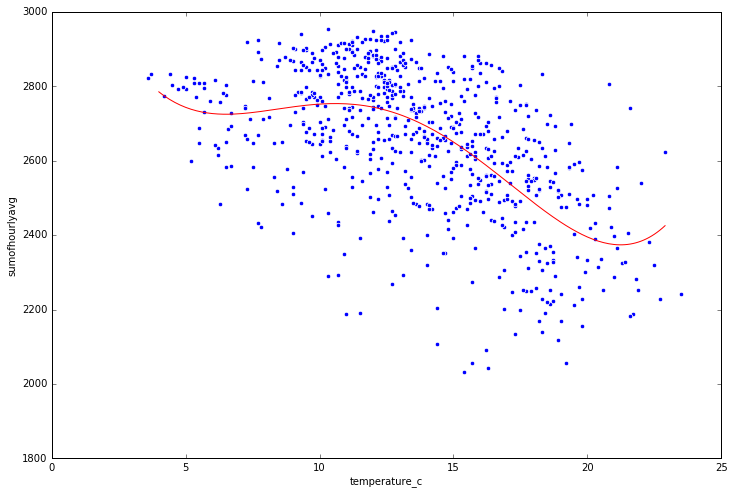

In [92]:
# finding indices where rain_MA is finite (meaning, where rain_MA is non-zero)
rain_idx = np.isfinite(bikeData['rain_MA'].values) & np.isfinite(bikeData['sumofhourlyavg'].values)

# fitting polynomials to each input dataset in relation to the aggregate bike availability
# NOTE: when making station-wise, each station needs 3 of its own sets of coefficients in relation to that station's bike-availability
p_coeffsTemp = np.polyfit(bikeData['temperature_c'].values, bikeData['sumofhourlyavg'].values, 4)
p_coeffsRain = np.polyfit(bikeData['rain_MA'].values[rain_idx], bikeData['sumofhourlyavg'].values[rain_idx], 2)
p_coeffsHours = np.polyfit(bikeData['hour'].values, bikeData['sumofhourlyavg'].values, 7)

xx_temp = np.arange(4,23,0.1)
yy_temp = np.zeros(len(xx_temp))
for i in range(len(xx_temp)):
    yy_temp[i] = np.polyval(p_coeffsTemp, xx_temp[i])

xx_rain = np.arange(0, 3.02, 0.02)
yy_rain = np.zeros(len(xx_rain))
for i in range(len(xx_rain)):
    yy_rain[i] = np.polyval(p_coeffsRain, xx_rain[i])
    
xx_hour = np.arange(0, 24, 1)
yy_hour = np.zeros(len(xx_hour))
for i in range(len(xx_hour)):
    yy_hour[i] = np.polyval(p_coeffsHours, xx_hour[i])
    

# Producing three scatterplots to investigate the relationships: availability vs. temperature, availability vs. precipitation, availability vs. hour of the day
fig, ax = plt.subplots(1, 1, figsize=(12,8))
aax = sns.scatterplot(x='temperature_c', y='sumofhourlyavg', data=bikeData)
plt.plot(xx_temp, yy_temp,'r')

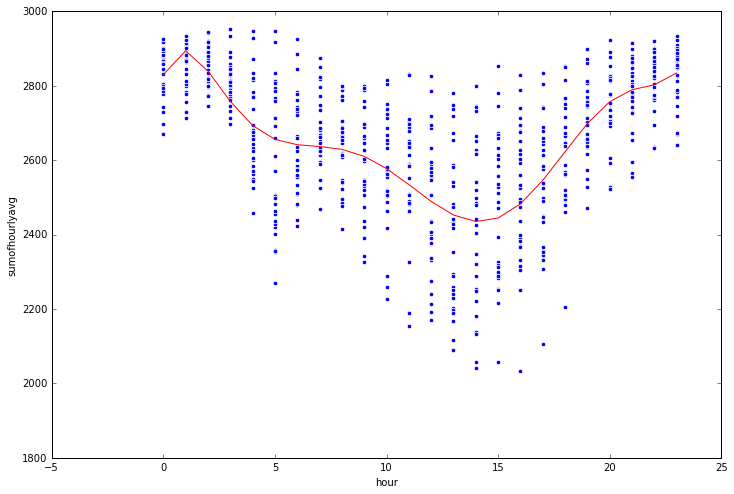

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ddx = sns.scatterplot(x=bikeData['hour'], y=bikeData['sumofhourlyavg']) # hour of the day
plt.plot(xx_hour, yy_hour,'r')

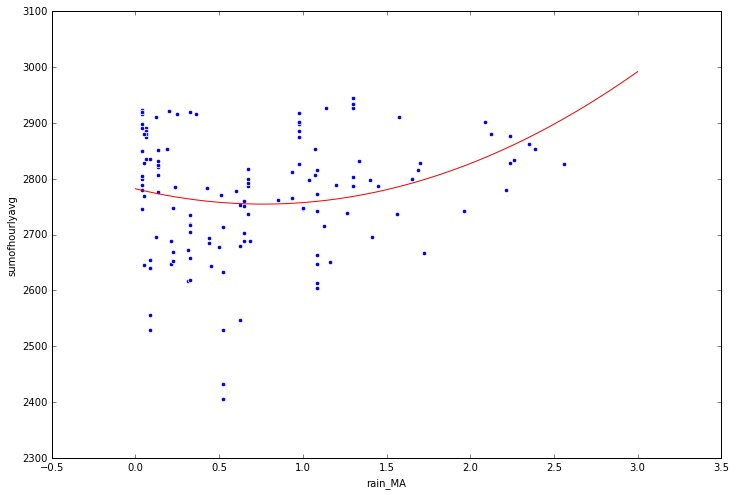

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
bx = sns.scatterplot(x='rain_MA', y='sumofhourlyavg', data=bikeData)
plt.plot(xx_rain, yy_rain,'r')

Coefficient of determination (R^2): 0.6079392618867018


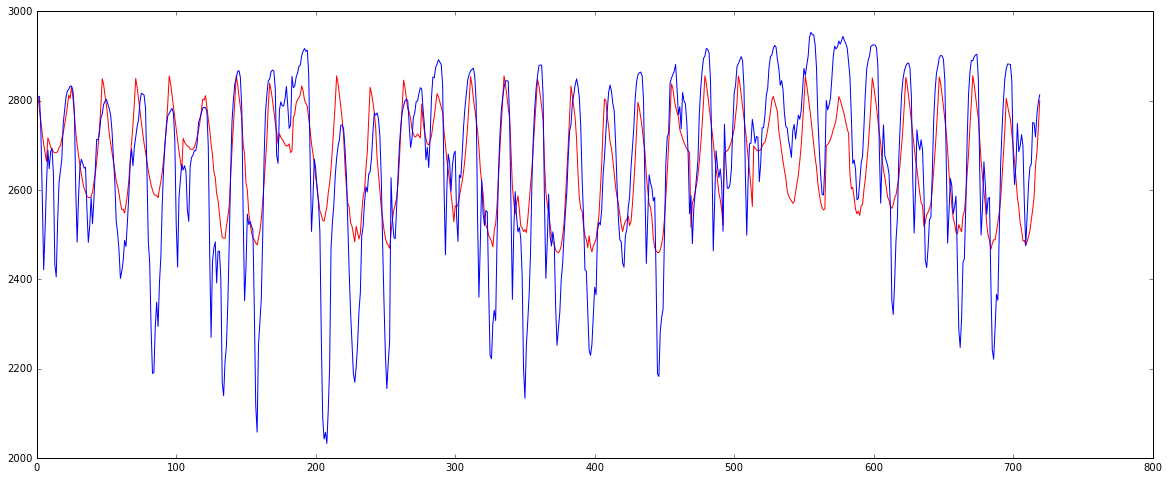

In [38]:
# Conditional mixed model, combining n:th order polynomial predictors as a weighted sum (with special conditions for recent rain)
bikeData['y_hat'] = np.zeros(len(bikeData['sumofhourlyavg']))
for i in range(len(bikeData['sumofhourlyavg'])):
    if (np.isnan(bikeData['rain_MA'].values[i])):
        temp_val = np.polyval(p_coeffsTemp, bikeData['temperature_c'].values[i])
        hour_val = np.polyval(p_coeffsHours, bikeData['hour'].values[i])
        bikeData['y_hat'].values[i] = 0.34*temp_val + 0.66*hour_val
    else:
        rain_val = np.polyval(p_coeffsRain, bikeData['rain_MA'].values[i])
        hour_val = np.polyval(p_coeffsHours, bikeData['hour'].values[i])
        bikeData['y_hat'].values[i] = 0.71*rain_val + 0.29*hour_val

# NOTE: the coefficients used above were determined experimentally. It's likely that every station would do best with custom coefficients.
# We can move forward with these hardcoded coefficients but we may look into mathematical optimization of these coefficients for every station.
    
# creating R**2, which is the 'Coefficient of Determination':
corr = np.corrcoef(bikeData['y_hat'].values, bikeData['sumofhourlyavg'].values)
coeff_determination = corr[0][1]**2

print('Coefficient of determination (R^2):', coeff_determination)

fig, ax = plt.subplots(1, 1, figsize=(20,8))

# Predicted availability is the red line and the observed availability is the blue line
plt.plot(range(len(bikeData['sumofhourlyavg'])), bikeData['y_hat'], 'r', label='predicted availability')
plt.plot(range(len(bikeData['sumofhourlyavg'])), bikeData['sumofhourlyavg'], 'b', label='observed availability')

#0.357180251752 Only Temperature predictor
#0.367322958164 Temperature predictor used when no recent rain, Rain predictor used when rain happened recently
#0.607939261887 Temperature and hour predictors used when no recent rain, rain and hour predictors when rain happened recently 

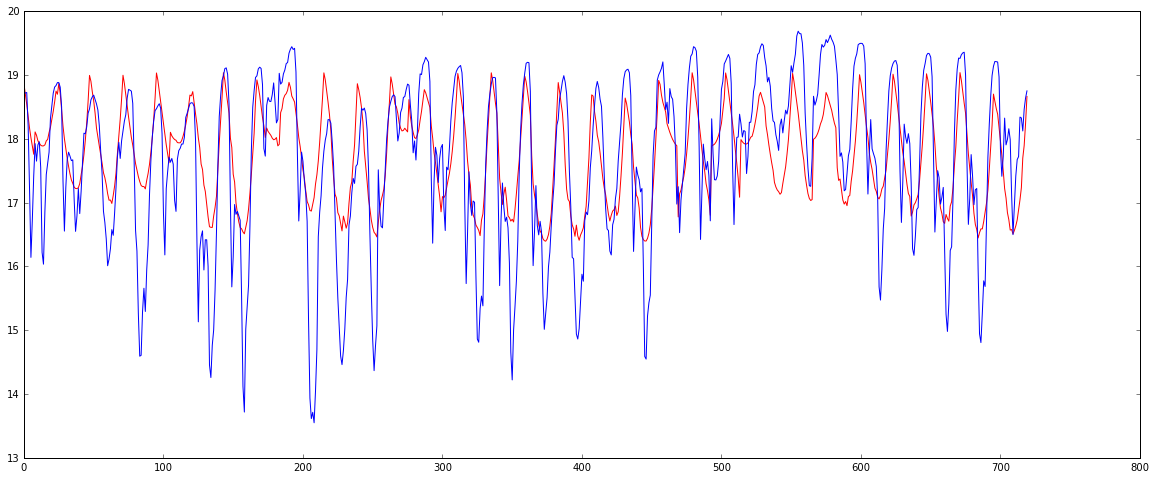

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
# prediction of bike-availability for the average station
# NOTE: should have much more interesting predicting power when done for each station
plt.plot(range(len(bikeData['sumofhourlyavg'])), bikeData['y_hat']/150, 'r', label='predicted availability')
plt.plot(range(len(bikeData['sumofhourlyavg'])), bikeData['sumofhourlyavg']/150, 'b', label='observed availability')




In [26]:
# exporting the predictions to a csv-file
bikeData.to_csv(r'/home/lea/anaconda3/projects/IntroToDS/y_hat.csv', sep=",")

## Station-wise predictor with y_hat predictions

- after running this you can make predictions for the front-end application by calling preds[stationID].predict(current_temperature, average_of_rain_over_last_8_hours, current_hour_of_the_day)
- the return value of this call is the estimated bike availability for this station identified by its stationID
- if you want a csv of the predicted values per station, then you have to make that yourself.  Otherwise, this should be ready to be used at the response of web-requests.

In [133]:
%matplotlib inline
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns

# Useful if the polynomials fit the data poorly, so the predictor would return the average availability for the station
#import warnings
#warnings.filterwarnings("error")


class BikeAvailabilityPredictor:
    def __init__(self, tempCoeffs, rainCoeffs, hoursCoeffs, maxAvailability):
        self.pCoeffsTemp = tempCoeffs
        self.pCoeffsRain = rainCoeffs
        self.pCoeffsHours = hoursCoeffs
        self.maxAvailability = maxAvailability

    def predict(self, temperature_c, rain_MA, hour):
        return_val = 0
        if (np.isnan(rain_MA) or rain_MA == 0):
            temp_val = np.polyval(self.pCoeffsTemp, temperature_c)
            hour_val = np.polyval(self.pCoeffsHours, hour)
            return_val = 0.29*temp_val + 0.71*hour_val  # 0.34 and 0.66
        else:
            rain_val = np.polyval(self.pCoeffsRain, rain_MA)
            hour_val = np.polyval(self.pCoeffsHours, hour)
            return_val = 0.72*rain_val + 0.28*hour_val # 0.71 and 0.29
        if return_val > self.maxAvailability:
            return self.maxAvailability
        if return_val < 0 or np.isnan(return_val):
            return 0
        return return_val

def readStationDataAndTrainPredictors():
    availPerStation = "bikeAvailability-2017-06-hourly-avg-per-station.csv"
    stationData = pd.read_csv(availPerStation, sep=',')
    weather_data_file = "fmi-weatherdata-Helsinki-Kaisaniemi-2017.csv"
    weatherData = pd.read_csv(weather_data_file, sep=",")
    weatherData.rename(columns={'Vuosi': 'Year', 'Kk': 'Month', 'Pv': 'Day', 'Klo': 'Time', 'Aikavyöhyke': 'Timezone', 'Sateen intensiteetti (mm/h)': 'rainIntensity_mmh', 'Ilman lämpötila (degC)': 'temperature_c'}, inplace=True)
    weatherData = weatherData[weatherData.Month == 6]
    weatherData["Time"] = weatherData["Time"].apply(lambda x: int(x.split(":")[0]))

    nRows = len(weatherData)

    weatherData['rain_MA'] = np.zeros(nRows)
    moving_average_window_size = 8

    for i in range(nRows):
        avg_val = 0
        sum_count = 0
        for j in range(moving_average_window_size):
            if (i-j >= 0):
                avg_val += weatherData['rainIntensity_mmh'].values[i-j] # moving average
                sum_count += 1
        avg_val /= sum_count
        weatherData['rain_MA'].values[i] = avg_val


    stationCount = 0
    predictors = {}
    for i in range(1, np.max(stationData['stationid'])):
        singleStation = stationData[stationData.stationid == i]
        if singleStation.empty:
            continue
        stationCount += 1

        avlbikes_idx = np.isfinite(singleStation['avlbikes'].values)
        rain_idx = np.nonzero(weatherData['rain_MA'].values.ravel())#& np.isfinite(singleStation['avlbikes'].values)

        if not max(avlbikes_idx): # this checks if avlbikes_idx is all Falses
            predictors[i] = BikeAvailabilityPredictor([0], [0], [0], 0)
        else:
            # fitting polynomials to each input dataset in relation to the station-wise bike availability
            try:
                p_coeffsTemp = np.polyfit(weatherData['temperature_c'].values[avlbikes_idx], singleStation['avlbikes'].values[avlbikes_idx], 4)
            except:
                print(str(i) + " temp")
                p_coeffsTemp = [np.mean(singleStation['avlbikes'].values[avlbikes_idx])]
            try:
                p_coeffsRain = np.polyfit(weatherData['rain_MA'].values[rain_idx], singleStation['avlbikes'].values[rain_idx], 2)
            except:
                print(str(i) + " rain")
                p_coeffsRain = [np.mean(singleStation['avlbikes'].values[avlbikes_idx])]
            try:
                p_coeffsHours = np.polyfit(weatherData['Time'].values[avlbikes_idx], singleStation['avlbikes'].values[avlbikes_idx], 7) # formerly 3rd degree
            except:
                print(str(i) + " hour")
                p_coeffsHours = [np.mean(singleStation['avlbikes'].values[avlbikes_idx])]
            predictors[i] = BikeAvailabilityPredictor(p_coeffsTemp, p_coeffsRain, p_coeffsHours, max(singleStation['avlbikes'].values[avlbikes_idx]))
                

    return predictors, weatherData, stationData
    # end of readStationDataAndTrainPredictors()

# Now using everything that was defined previously...
preds, weatherData, stationData = readStationDataAndTrainPredictors()

y_hat = np.zeros(720)
y = np.zeros(720)



# Analysis of R^2 by summing individual predictors and observations
for stationID, pred in preds.items():
    stationVals = stationData[stationData.stationid == stationID]['avlbikes'].values
    for i in range(720):
        actual_avl = stationVals[i]
        predicted_avl = 0
        if np.isnan(actual_avl):
            actual_avl = 0
        else:
            predicted_avl = pred.predict(weatherData['temperature_c'].values[i], weatherData['rain_MA'].values[i], weatherData['Time'].values[i])
        if np.isnan(predicted_avl):
            print(str(stationID) + " " + str(i)) # This should not print, there are problems if it does
        y_hat[i] += predicted_avl
        y[i] += actual_avl
    
    


print(y_hat)


[1384.55678344 1408.90048914 1389.63742236 1359.1872143  1334.517327
 1321.11230928 1316.31340145 1314.62155829 1330.15163141 1327.41523804
 1319.47689888 1313.50512557 1306.50517884 1301.51790162 1299.22172041
 1300.66766306 1308.58380668 1315.83657339 1330.07271049 1340.9109397
 1351.15165457 1355.88555158 1357.8505376  1362.21708595 1361.67698096
 1417.43598619 1398.56402814 1364.54192578 1336.21500616 1320.5551021
 1314.66496986 1312.63685981 1310.07619871 1303.62927816 1292.51567926
 1278.64595704 1262.8256601  1250.55391639 1244.54055317 1247.27486163
 1230.30736337 1256.67087477 1287.51001814 1317.71490262 1341.2137216
 1354.72337718 1361.5975197  1375.23546646 1375.96129902 1401.26481887
 1383.35174909 1350.57592709 1318.1791566  1301.46160463 1293.82863361
 1289.51143945 1283.01954324 1271.15126903 1259.17366643 1239.85960288
 1216.89519209 1198.97111908 1193.75155138 1193.31629835 1213.40899461
 1241.99777055 1276.77665246 1315.36450775 1341.95900951 1355.17274872
 1360.45598

In [132]:
print(sum(abs(y-y_hat))/720)

44.894516766768774


### Some notions on the y_hat predictions 

- the y_hat predictions here are the sum of every station's predicted availability per hour.
- the y is the sum of every station's actual availability per hour
- the values of y_hat and y seem to be half the magnitude of the 'sumofhourlyavg'. This is something to think about. 


Coefficient of determination (R^2) for the sum of station-wise predictions: 0.7085500852115348


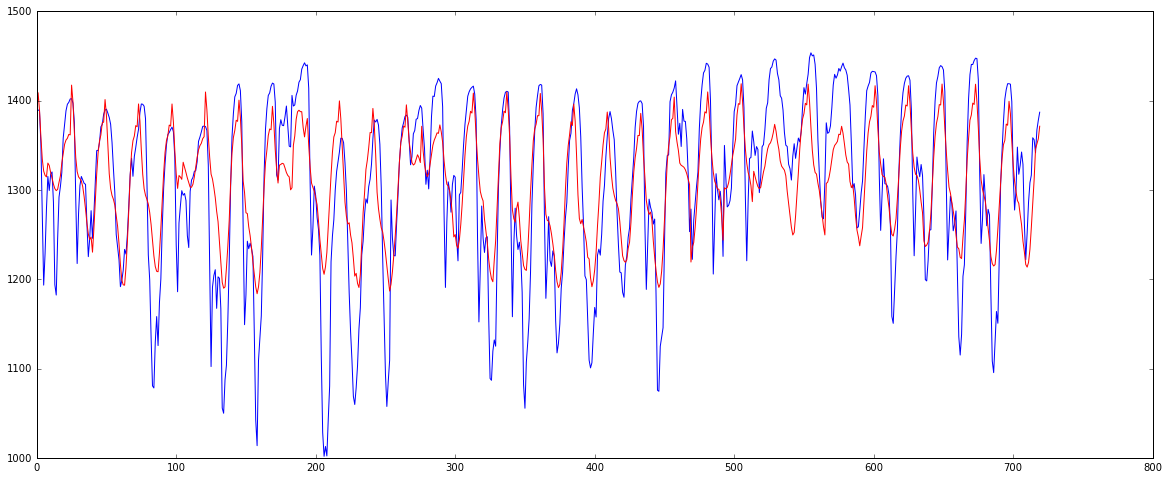

In [130]:
corr = np.corrcoef(y_hat, y)
coeff_determination = corr[0][1]**2
print('Coefficient of determination (R^2) for the sum of station-wise predictions:', coeff_determination)

fig, ax = plt.subplots(1, 1, figsize=(20,8))

plt.plot(range(720), y, 'b')
plt.plot(range(720), y_hat, 'r')

# 0.6948205167224671
# 0.6964515819852269
# 0.6965221241303688
# 0.6965541676718427
# 0.7085500852115348

# the correlation is sqrt(0.7085500852115348) = 0,841754121

In [ ]:
# exporting the predictions to a csv-file
y_hat.to_csv(r'/home/lea/anaconda3/projects/IntroToDS/y_hat_stationwise.csv', sep=",")